# Logistic Regression with L2 regularization

In [124]:
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6
import pandas as pd
import numpy as np
import string
import json

DATA_DIR = './data/week2/'

## Inspect and clean data

In [10]:
products = pd.read_csv(DATA_DIR + 'amazon_baby_subset.csv')

products.info()
print('\n')
products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53072 entries, 0 to 53071
Data columns (total 4 columns):
name         52982 non-null object
review       52831 non-null object
rating       53072 non-null int64
sentiment    53072 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.6+ MB




,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [12]:
def remove_ponctuation(s):
    s = s.translate(None, string.punctuation)
    return s

# remove ponctuation from the review colum
products['review'] = products['review'].fillna('')
products['review'] = products['review'].apply(remove_ponctuation)

important_words = open(DATA_DIR + 'important_words.json').read()
important_words = json.loads(important_words)

for word in important_words:
    products[word] = products['review'].apply(lambda s : s.split().count(word))

products.head()

,name,review,rating,sentiment,baby,one,great,love,use,would,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried nonstop when I tried...,5,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago S...,5,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You",One of babys first and favorite books and it i...,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book My son loves this b...,5,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Train-Validation split

In [18]:
# Split the dataframe into a training and test set
train_indices = open(DATA_DIR + 'module-4-assignment-train-idx.json').read()
train_indices = json.loads(train_indices)
test_indices = open(DATA_DIR + 'module-4-assignment-validation-idx.json').read()
test_indices = json.loads(test_indices)

train_data = products.iloc[train_indices]
validation_data = products.iloc[test_indices]

## Convert data frame to multi-dimensional array

In [21]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [23]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients 
    score = np.dot(feature_matrix, coefficients)
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1 / (1+np.exp(-score))
    return predictions

def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant):  
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
    
    if not feature_is_constant:
        derivative -= 2*l2_penalty*coefficient
    
    # Return the derivative
    return derivative

#### In the code above, was the intercept term regularized ?

No, the intercept term was not regularized.

In [26]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

## Explore effects of L2 regularization

In [32]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            # YOUR CODE HERE
            is_intercept = (j == 0)
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)

            # add the step size times the derivative to the current coefficient
            # YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size * derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

print('Logiistic regression with L2 penalty 0 :')
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, np.zeros(194), 0.000005, 0, 501)
print('\nLogiistic regression with L2 penalty 4 :')
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, np.zeros(194), 0.000005, 4, 501)
print('\nLogiistic regression with L2 penalty 10 :')
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, np.zeros(194), 0.000005, 10, 501)
print('\nLogiistic regression with L2 penalty 100 :')
coefficients_100_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, np.zeros(194), 0.000005, 100, 501)
print('\nLogiistic regression with L2 penalty 1000 :')
coefficients_1000_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, np.zeros(194), 0.000005, 1000, 501)
print('\nLogiistic regression with L2 penalty 100000 :')
coefficients_100000_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train, np.zeros(194), 0.000005, 100000, 501)

Logiistic regression with L2 penalty 0 :
iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log li

iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.42422295
iteration  15: log likelihood of observed labels = -27379.97375625
iteration  20: log likelihood of observed labels = -27027.18208317
iteration  30: log likelihood of observed labels = -26527.22737267
iteration  40: log likelihood of observed labels = -26206.59048765
iteration  50: log likelihood of observed labels = -25995.9690

## Compare coefficients

In [55]:
learned_coefficients = pd.DataFrame(data={
    'words': important_words,
    'coefficients_0_penalty': coefficients_0_penalty[1:],
    'coefficients_4_penalty': coefficients_4_penalty[1:],
    'coefficients_10_penalty': coefficients_10_penalty[1:],
    'coefficients_100_penalty': coefficients_100_penalty[1:],
    'coefficients_1000_penalty': coefficients_1000_penalty[1:],
    'coefficients_100000_penalty': coefficients_100000_penalty[1:]
})

Which of the following is not listed in either positive_words or negative_words ?

In [58]:
learned_coefficients = learned_coefficients.sort_values(by='coefficients_0_penalty', ascending=0)

positive_words = learned_coefficients['words'].iloc[0:5]
negative_words = learned_coefficients['words'].iloc[-5:]

print('The 5 most positive words are : ' + ', '.join(positive_words) + '.')
print('The 5 most negative words are : ' + ', '.join(negative_words) + '.')

The 5 most positive words are : love, loves, easy, perfect, great.
The 5 most negative words are : returned, waste, return, money, disappointed.


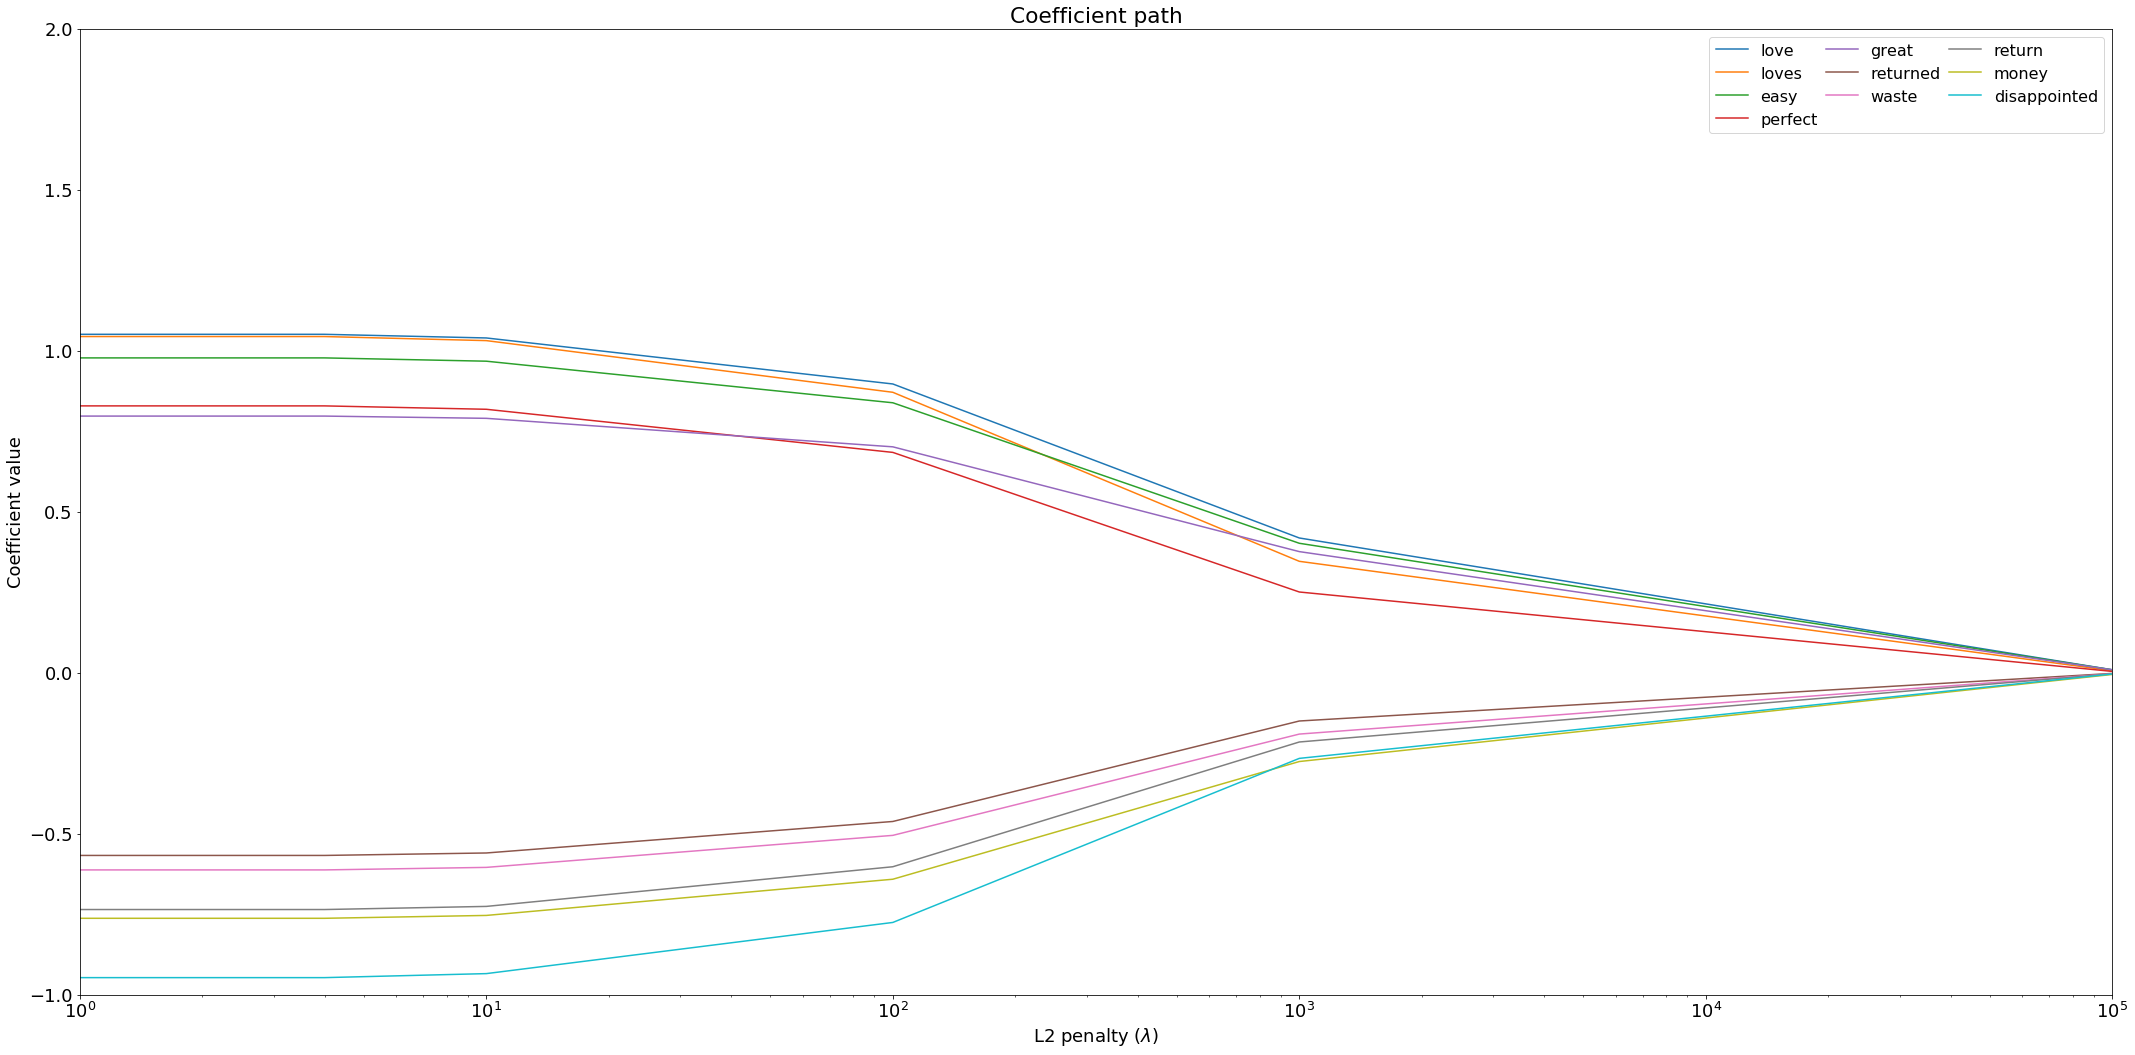

In [121]:
extreme_words_coefficients = learned_coefficients.iloc[0:5]
extreme_words_coefficients = extreme_words_coefficients.append(learned_coefficients.iloc[-5:])
extreme_words_coefficients = extreme_words_coefficients[['coefficients_0_penalty', 'coefficients_4_penalty', 
                                                         'coefficients_10_penalty', 'coefficients_100_penalty',
                                                         'coefficients_1000_penalty', 'coefficients_100000_penalty',
                                                         'words']]
L2_penalties = [0,4 ,10, 100, 1000, 100000]
plt.figure(figsize=(30,15))
for i in range(10):
    plt.plot(L2_penalties, extreme_words_coefficients.iloc[i,:-1], label=extreme_words_coefficients.iloc[i,-1])
    
plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
plt.axis([1, 1e5, -1, 2])
plt.title('Coefficient path')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('Coefficient value')
plt.xscale('log')
plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.show()


#### All coefficients consistently get smaller in size as L2 penalty is increased ?

Yes

#### Relative order of coefficients is preserved as L2 penalty is increased?

No

## Measuring accuracy

#### Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the training data?

In [144]:
train_accuracies = []
coefficients_penalties = [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty,
                          coefficients_100_penalty, coefficients_1000_penalty, coefficients_100000_penalty]
for coefficients_penalty in coefficients_penalties:
    if learned_coefficients[column].name != 'words':
        predicted_probabilities = predict_probability(feature_matrix_train, coefficients_penalty)
        predictions = np.empty(feature_matrix_train.shape[0])
        predictions.fill(-1)
        predictions[predicted_probabilities > 0.5] = 1
        accuracy = accuracy_score(sentiment_train, predictions)
        train_accuracies.append(accuracy)
        
train_accuracies = [str(accuracy) for accuracy in train_accuracies]
print('The accuracies for the L2 penatlies with values 0, 4, 10, 100, 1000 and 100000 are respectively : ' + 
      ', '.join(train_accuracies) + '.')
print('\n')
print('We can see that the model with the highest accuracy on the training data is the model with value 0 \
for the l2 penalty.')

The accuracies for the L2 penatlies with values 0, 4, 10, 100, 1000 and 100000 are respectively : 0.785156157787, 0.785108944548, 0.784990911452, 0.783975826822, 0.775855149784, 0.680366374731.


We can see that the model with the highest accuracy on the training data is the model with value 0 for the l2 penalty.


#### Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the highest accuracy on the validation data ?

In [143]:
validation_accuracies = []
for coefficients_penalty in coefficients_penalties:
    if learned_coefficients[column].name != 'words':
        predicted_probabilities = predict_probability(feature_matrix_valid, coefficients_penalty)
        predictions = np.empty(feature_matrix_valid.shape[0])
        predictions.fill(-1)
        predictions[predicted_probabilities > 0.5] = 1
        accuracy = accuracy_score(sentiment_valid, predictions)
        validation_accuracies.append(accuracy)
        
validation_accuracies = [str(accuracy) for accuracy in validation_accuracies]
print('The accuracies for the L2 penatlies with values 0, 4, 10, 100, 1000 and 100000 are respectively : ' + 
      ', '.join(validation_accuracies) + '.')
print('\n')
print('We can see that the model with the highest accuracy on the validation data is the model with value 10 \
for the l2 penalty.')

The accuracies for the L2 penatlies with values 0, 4, 10, 100, 1000 and 100000 are respectively : 0.78143964149, 0.781533003454, 0.781719727383, 0.781066193633, 0.771356549342, 0.667818130893


We can see that the model with the highest accuracy on the validation data is the model with value 10 for the l2 penalty


## Does the highest accuracy on the training data imply that the model is the best one ?

No. On the previously computed accuracies we can see that model with L2 penalty value 10 has lower training accuracy that the model with  L2 penalty value 0 but better validation accuracy.